# Custom training: walkthrough

This guide uses machine learning to *categorize* Iris flowers by species. It uses TensorFlow's [eager execution](https://www.tensorflow.org/r1/guide/eager) to:
1. Build a model,
2. Train this model on example data, and
3. Use the model to make predictions about unknown data.

## TensorFlow programming

This guide uses these high-level TensorFlow concepts:

* Enable an [eager execution](https://www.tensorflow.org/r1/guide/eager) development environment,
* Import data with the [Datasets API](https://www.tensorflow.org/r1/guide/datasets),
* Build models and layers with TensorFlow's [Keras API](https://keras.io/getting-started/sequential-model-guide/).

This tutorial is structured like many TensorFlow programs:

1. Import and parse the data sets.
2. Select the type of model.
3. Train the model.
4. Evaluate the model's effectiveness.
5. Use the trained model to make predictions.

### Configure imports and eager execution

Eager execution makes TensorFlow evaluate operations immediately, returning concrete values instead of creating a [computational graph](https://www.tensorflow.org/r1/guide/graphs) that is executed later. If you are used to a REPL or the `python` interactive console, this feels familiar. Eager execution is available in [Tensorlow >=1.8](https://www.tensorflow.org/install/).

Once eager execution is enabled, it *cannot* be disabled within the same program. See the [eager execution guide](https://www.tensorflow.org/r1/guide/eager) for more details.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import matplotlib.pyplot as plt

import tensorflow as tf

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.14.0
Eager execution: True


## The Iris classification problem

Imagine you are a botanist seeking an automated way to categorize each Iris flower you find. Machine learning provides many algorithms to classify flowers statistically. For instance, a sophisticated machine learning program could classify flowers based on photographs. Our ambitions are more modest—we're going to classify Iris flowers based on the length and width measurements of their [sepals](https://en.wikipedia.org/wiki/Sepal) and [petals](https://en.wikipedia.org/wiki/Petal).

The Iris genus entails about 300 species, but our program will only classify the following three:

* Iris setosa
* Iris virginica
* Iris versicolor

<table>
  <tr><td>
    <img src="https://www.tensorflow.org/images/iris_three_species.jpg"
         alt="Petal geometry compared for three iris species: Iris setosa, Iris virginica, and Iris versicolor">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://commons.wikimedia.org/w/index.php?curid=170298">Iris setosa</a> (by <a href="https://commons.wikimedia.org/wiki/User:Radomil">Radomil</a>, CC BY-SA 3.0), <a href="https://commons.wikimedia.org/w/index.php?curid=248095">Iris versicolor</a>, (by <a href="https://commons.wikimedia.org/wiki/User:Dlanglois">Dlanglois</a>, CC BY-SA 3.0), and <a href="https://www.flickr.com/photos/33397993@N05/3352169862">Iris virginica</a> (by <a href="https://www.flickr.com/photos/33397993@N05">Frank Mayfield</a>, CC BY-SA 2.0).<br/>&nbsp;
  </td></tr>
</table>

Fortunately, someone has already created a [data set of 120 Iris flowers](https://en.wikipedia.org/wiki/Iris_flower_data_set) with the sepal and petal measurements. This is a classic dataset that is popular for beginner machine learning classification problems.

## Import and parse the training dataset

Download the training dataset file using the [tf.keras.utils.get_file](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file) function. This returns the file path of the downloaded file.

In [2]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: C:\Users\user\.keras\datasets\iris_training.csv


In [3]:
# column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


Each label is associated with string name (for example, "setosa"), but machine learning typically relies on numeric values. The label numbers are mapped to a named representation, such as:

* `0`: Iris setosa
* `1`: Iris versicolor
* `2`: Iris virginica

For more information about features and labels, see the [ML Terminology section of the Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/framing/ml-terminology).

In [4]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

### Create a `tf.data.Dataset`

TensorFlow's [Dataset API](https://www.tensorflow.org/r1/guide/datasets) handles many common cases for loading data into a model. This is a high-level API for reading data and transforming it into a form used for training.

In [5]:
batch_size = 32

train_dataset = tf.contrib.data.make_csv_dataset(train_dataset_fp,
                                                 batch_size,
                                                 column_names=column_names,
                                                 label_name=label_name,
                                                 num_epochs=1)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.data.experimental.make_csv_dataset(...)`.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


The `make_csv_dataset` function returns a `tf.data.Dataset` of `(features, label)` pairs, where `features` is a dictionary: `{'feature_name': value}`

With eager execution enabled, these `Dataset` objects are iterable. Let's look at a batch of features:

In [6]:
features, labels = next(iter(train_dataset))

features

OrderedDict([('sepal_length',
              <tf.Tensor: id=65, shape=(32,), dtype=float32, numpy=
              array([6.6, 5. , 6.9, 7.2, 4.8, 7.7, 5.8, 5.8, 5.2, 5.9, 6.1, 4.6, 6.7,
                     5.7, 6.7, 5.8, 5.2, 6.4, 5.8, 6.8, 4.6, 5.9, 6.6, 6.2, 5.5, 5. ,
                     6.9, 5.1, 5.8, 4.8, 6.3, 4.4], dtype=float32)>),
             ('sepal_width',
              <tf.Tensor: id=66, shape=(32,), dtype=float32, numpy=
              array([3. , 3.6, 3.1, 3. , 3.1, 2.6, 2.7, 4. , 2.7, 3.2, 2.8, 3.2, 3.3,
                     3.8, 3. , 2.7, 3.5, 3.2, 2.6, 3.2, 3.1, 3. , 2.9, 2.2, 2.4, 3.3,
                     3.1, 3.8, 2.8, 3.4, 2.7, 2.9], dtype=float32)>),
             ('petal_length',
              <tf.Tensor: id=63, shape=(32,), dtype=float32, numpy=
              array([4.4, 1.4, 4.9, 5.8, 1.6, 6.9, 5.1, 1.2, 3.9, 4.8, 4.7, 1.4, 5.7,
                     1.7, 5. , 5.1, 1.5, 4.5, 4. , 5.9, 1.5, 5.1, 4.6, 4.5, 3.7, 1.4,
                     5.1, 1.5, 5.1, 1.6, 4.9, 1.4],

In [7]:
features.keys()

odict_keys(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])

Notice that like-features are grouped together, or *batched*. Each example row's fields are appended to the corresponding feature array. Change the `batch_size` to set the number of examples stored in these feature arrays.

You can start to see some clusters by plotting a few features from the batch:

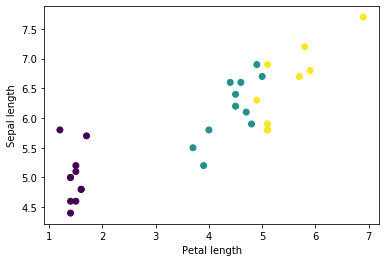

In [8]:
plt.scatter(features['petal_length'].numpy(),
            features['sepal_length'].numpy(),
            c=labels.numpy(),
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

To simplify the model building step, create a function to repackage the features dictionary into a single array with shape: `(batch_size, num_features)`.

This function uses the [tf.stack](https://www.tensorflow.org/api_docs/python/tf/stack) method which takes values from a list of tensors and creates a combined tensor at the specified dimension.

In [9]:
def pack_features_vector(features, labels):
    """Pack the features into a single array."""
    features = tf.stack(list(features.values()), axis=1)
    return features, labels

Then use the [tf.data.Dataset.map](https://www.tensorflow.org/api_docs/python/tf/data/dataset/map) method to pack the `features` of each `(features,label)` pair into the training dataset:

In [10]:
train_dataset = train_dataset.map(pack_features_vector)

The features element of the `Dataset` are now arrays with shape `(batch_size, num_features)`. Let's look at the first few examples:

In [11]:
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[6.6 3.  4.4 1.4]
 [5.  3.6 1.4 0.2]
 [6.9 3.1 4.9 1.5]
 [7.2 3.  5.8 1.6]
 [4.8 3.1 1.6 0.2]], shape=(5, 4), dtype=float32)


## Select the type of model

### Why model?

A *[model](https://developers.google.com/machine-learning/crash-course/glossary#model)* is a relationship between features and the label.  


### Select the model

<table>
  <tr><td>
    <img src="https://www.tensorflow.org/images/custom_estimators/full_network.png"
         alt="A diagram of the network architecture: Inputs, 2 hidden layers, and outputs">
  </td></tr>
  <tr><td align="center">
    <b>Figure 2.</b> A neural network with features, hidden layers, and predictions.<br/>&nbsp;
  </td></tr>
</table>


### Create a model using Keras

In [12]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

In [13]:
predictions = model(features)
predictions[:5]

<tf.Tensor: id=206, shape=(5, 3), dtype=float32, numpy=
array([[ 0.6373292 , -0.35868758, -1.6531713 ],
       [ 0.52544224, -0.39505142, -1.1819564 ],
       [ 0.6712927 , -0.36413795, -1.7641312 ],
       [ 0.7062261 , -0.34043607, -1.9308693 ],
       [ 0.4936991 , -0.3426926 , -1.164639  ]], dtype=float32)>

Here, each example returns a [logit](https://developers.google.com/machine-learning/crash-course/glossary#logits) for each class.

To convert these logits to a probability for each class, use the [softmax](https://developers.google.com/machine-learning/crash-course/glossary#softmax) function:

In [14]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: id=212, shape=(5, 3), dtype=float32, numpy=
array([[0.68001145, 0.25116068, 0.06882789],
       [0.63304794, 0.25215712, 0.11479495],
       [0.69317645, 0.24612854, 0.06069496],
       [0.70290047, 0.24679378, 0.05030578],
       [0.6158674 , 0.2668375 , 0.11729516]], dtype=float32)>

Taking the `tf.argmax` across classes gives us the predicted class index. But, the model hasn't been trained yet, so these aren't good predictions.

In [15]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
    Labels: [1 0 1 2 0 2 2 0 1 1 1 0 2 0 1 2 0 1 1 2 0 2 1 1 1 0 2 0 2 0 2 0]


### Define the loss and gradient function


In [16]:
def loss(model, x, y):
    y_ = model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)


l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: 1.4609649181365967


Use the [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) context to calculate the *[gradients](https://developers.google.com/machine-learning/crash-course/glossary#gradient)* used to optimize our model. For more examples of this, see the [eager execution guide](https://www.tensorflow.org/r1/guide/eager).

In [17]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
        
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

### Create an optimizer

An *[optimizer](https://developers.google.com/machine-learning/crash-course/glossary#optimizer)* applies the computed gradients to the model's variables to minimize the `loss` function. You can think of the loss function as a curved surface (see Figure 3) and we want to find its lowest point by walking around. The gradients point in the direction of steepest ascent—so we'll travel the opposite way and move down the hill. By iteratively calculating the loss and gradient for each batch, we'll adjust the model during training. Gradually, the model will find the best combination of weights and bias to minimize loss. And the lower the loss, the better the model's predictions.

<table>
  <tr><td>
    <img src="https://cs231n.github.io/assets/nn3/opt1.gif" width="70%"
         alt="Optimization algorithms visualized over time in 3D space.">
  </td></tr>
  <tr><td align="center">
    <b>Figure 3.</b> Optimization algorithms visualized over time in 3D space.<br/>(Source: <a href="http://cs231n.github.io/neural-networks-3/">Stanford class CS231n</a>, MIT License, Image credit: <a href="https://twitter.com/alecrad">Alec Radford</a>)
  </td></tr>
</table>

TensorFlow has many [optimization algorithms](https://www.tensorflow.org/api_guides/python/train) available for training. This model uses the [tf.train.GradientDescentOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer) that implements the *[stochastic gradient descent](https://developers.google.com/machine-learning/crash-course/glossary#gradient_descent)* (SGD) algorithm. The `learning_rate` sets the step size to take for each iteration down the hill. This is a *hyperparameter* that you'll commonly adjust to achieve better results.

Let's setup the optimizer and the `global_step` counter:

In [18]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

global_step = tf.Variable(0)

We'll use this to calculate a single optimization step:

In [19]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step)

print("Step: {},         Loss: {}".format(global_step.numpy(),
                                          loss(model, features, labels).numpy()))

Step: 0, Initial Loss: 1.4609649181365967
Step: 1,         Loss: 1.3479862213134766


### Training loop

With all the pieces in place, the model is ready for training! A training loop feeds the dataset examples into the model to help it make better predictions. The following code block sets up these training steps:

1. Iterate each *epoch*. An epoch is one pass through the dataset.
2. Within an epoch, iterate over each example in the training `Dataset` grabbing its *features* (`x`) and *label* (`y`).
3. Using the example's features, make a prediction and compare it with the label. Measure the inaccuracy of the prediction and use that to calculate the model's loss and gradients.
4. Use an `optimizer` to update the model's variables.
5. Keep track of some stats for visualization.
6. Repeat for each epoch.

The `num_epochs` variable is the number of times to loop over the dataset collection. Counter-intuitively, training a model longer does not guarantee a better model. `num_epochs` is a *[hyperparameter](https://developers.google.com/machine-learning/glossary/#hyperparameter)* that you can tune. Choosing the right number usually requires both experience and experimentation.

In [20]:
## Note: Rerunning this cell uses the same model variables

from tensorflow import contrib
tfe = contrib.eager

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 200

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()

    # Training loop - using batches of 32
    for x, y in train_dataset:
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step)

    # Track progress
    epoch_loss_avg(loss_value)  # add current batch loss
    
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

    # end epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if (epoch+1) % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch+1,
                                                                    epoch_loss_avg.result(),
                                                                    epoch_accuracy.result()))

Epoch 050: Loss: 0.539, Accuracy: 75.000%
Epoch 100: Loss: 0.355, Accuracy: 87.500%
Epoch 150: Loss: 0.270, Accuracy: 91.667%
Epoch 200: Loss: 0.232, Accuracy: 91.667%


### Visualize the loss function over time

While it's helpful to print out the model's training progress, it's often *more* helpful to see this progress. [TensorBoard](https://www.tensorflow.org/r1/guide/summaries_and_tensorboard) is a nice visualization tool that is packaged with TensorFlow, but we can create basic charts using the `matplotlib` module.

Interpreting these charts takes some experience, but you really want to see the *loss* go down and the *accuracy* go up.

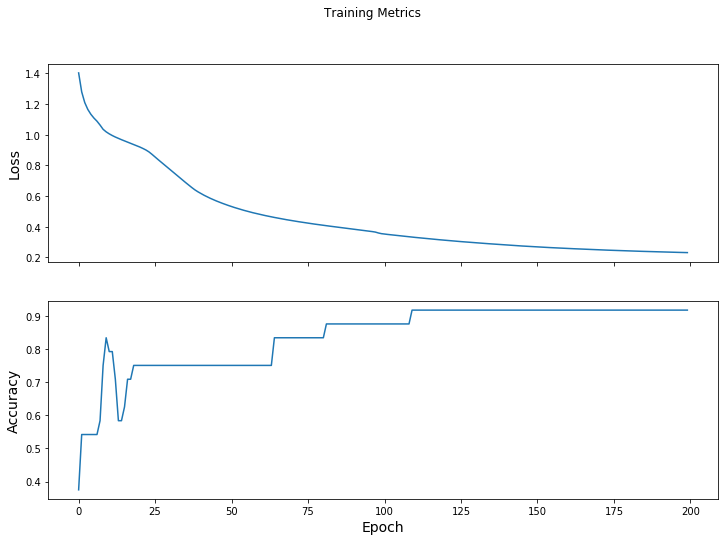

In [21]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

## Evaluate the model's effectiveness

Now that the model is trained, we can get some statistics on its performance.

*Evaluating* means determining how effectively the model makes predictions. To determine the model's effectiveness at Iris classification, pass some sepal and petal measurements to the model and ask the model to predict what Iris species they represent. Then compare the model's prediction against the actual label.  For example, a model that picked the correct species on half the input examples has an *[accuracy](https://developers.google.com/machine-learning/glossary/#accuracy)* of `0.5`. Figure 4 shows a slightly more effective model, getting 4 out of 5 predictions correct at 80% accuracy:

<table cellpadding="8" border="0">
  <colgroup>
    <col span="4" >
    <col span="1" bgcolor="lightblue">
    <col span="1" bgcolor="lightgreen">
  </colgroup>
  <tr bgcolor="lightgray">
    <th colspan="4">Example features</th>
    <th colspan="1">Label</th>
    <th colspan="1" >Model prediction</th>
  </tr>
  <tr>
    <td>5.9</td><td>3.0</td><td>4.3</td><td>1.5</td><td align="center">1</td><td align="center">1</td>
  </tr>
  <tr>
    <td>6.9</td><td>3.1</td><td>5.4</td><td>2.1</td><td align="center">2</td><td align="center">2</td>
  </tr>
  <tr>
    <td>5.1</td><td>3.3</td><td>1.7</td><td>0.5</td><td align="center">0</td><td align="center">0</td>
  </tr>
  <tr>
    <td>6.0</td> <td>3.4</td> <td>4.5</td> <td>1.6</td> <td align="center">1</td><td align="center" bgcolor="red">2</td>
  </tr>
  <tr>
    <td>5.5</td><td>2.5</td><td>4.0</td><td>1.3</td><td align="center">1</td><td align="center">1</td>
  </tr>
  <tr><td align="center" colspan="6">
    <b>Figure 4.</b> An Iris classifier that is 80% accurate.<br/>&nbsp;
  </td></tr>
</table>

### Setup the test dataset


In [22]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

In [23]:
test_dataset = tf.contrib.data.make_csv_dataset(test_fp,
                                                batch_size,
                                                column_names=column_names,
                                                label_name='species',
                                                num_epochs=1,
                                                shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

### Evaluate the model on the test dataset

Unlike the training stage, the model only evaluates a single [epoch](https://developers.google.com/machine-learning/glossary/#epoch) of the test data. In the following code cell, we iterate over each example in the test set and compare the model's prediction against the actual label. This is used to measure the model's accuracy across the entire test set.

In [24]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
    logits = model(x)
    prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
    test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%


We can see on the last batch, for example, the model is usually correct:

In [25]:
tf.stack([y, prediction], axis=1)

<tf.Tensor: id=85352, shape=(30, 2), dtype=int32, numpy=
array([[1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [2, 2],
       [1, 1],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1]])>

## Use the trained model to make predictions

We've trained a model and "proven" that it's good—but not perfect—at classifying Iris species. Now let's use the trained model to make some predictions on [unlabeled examples](https://developers.google.com/machine-learning/glossary/#unlabeled_example); that is, on examples that contain features but not a label.

In real-life, the unlabeled examples could come from lots of different sources including apps, CSV files, and data feeds. For now, we're going to manually provide three unlabeled examples to predict their labels. Recall, the label numbers are mapped to a named representation as:

* `0`: Iris setosa
* `1`: Iris versicolor
* `2`: Iris virginica

In [26]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
    class_idx = tf.argmax(logits).numpy()
    p = tf.nn.softmax(logits)[class_idx]
    name = class_names[class_idx]
    print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Iris setosa (97.6%)
Example 1 prediction: Iris versicolor (86.8%)
Example 2 prediction: Iris virginica (72.8%)
